# dask_awkward, dask_histogram, and coffea @ Dask Demo Day (20 April 2023)

These packages are new parts of the dask ecosystem that high-energy particle physicists explore
and scale out their analyses using dask as opposed to using cluster schedulers directly. This
latter restriction has long held High Energy Physics (HEP) analysis within the realm of 
simple, pleasingly parallel execution patterns on distribute compute. Now, we can design analyses
and the correct locations and junctures for non-embarassingly parallel operations will 
be discovered for us. In time, this will lead to analyses with table joins, repartitioning, and

In particular, high energy physics pythonic analyses use the [awkward-array](https://github.com/scikit-hep/awkward) package
to do data manipulations and the [uproot](https://github.com/scikit-hep/uproot5) package to read our
specialized event record formats. We most often convey the results of our analyses over multiple O(20-50)
datasets through histograms, accomplished using the [hist](https://github.com/scikit-hep/hist) package.
We'll touch upon the highly-structured nature of HEP data and why we need these custom, but now generalized solutions.

Today we'll go through what's possible right now with [dask-awkward](https://github.com/dask-contrib/dask-awkward), [dask-histogram](https://github.com/dask-contrib/dask-histogram), and [coffea](https://github.com/coffeateam/coffea).
Some of the examples below are using release candidates. Pardon the dust. :-)

When using coffea below, it is all with the latest release candidate.

In [ ]:
!pip install --pre coffea
!pip install graphviz 'dask[distributed]' 'bokeh>=2.4.2,<3' --upgrade

## Example 0: Basic functionality, column extraction specificity, parallelism

1.4325431250000005


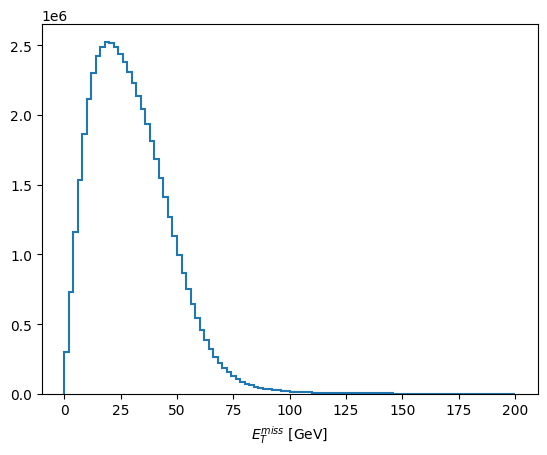

In [5]:
import uproot
import hist
import time

tic = time.monotonic()
hist.Hist.new \
   .Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]").Double() \
   .fill(met=uproot.open("./Run2012B_SingleMu.root:Events")["MET_pt"].array()) \
   .plot();

print(time.monotonic() - tic)

HighLevelGraph with 1 layers.
 0. from-uproot-67d42b83b807b851f6e786b817f265e2



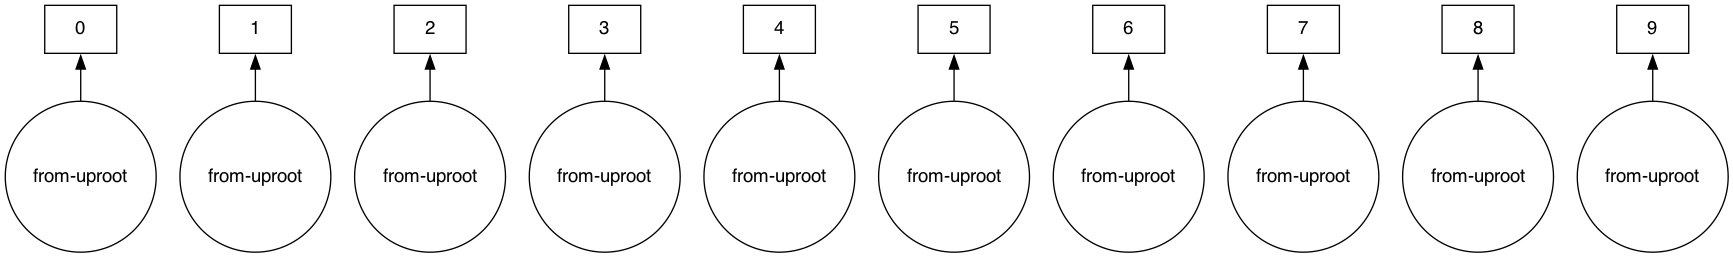

In [2]:
import uproot

x = uproot.dask({"./Run2012B_SingleMu.root": "Events"}, steps_per_file=10)
print(x.dask)
x.visualize()

In [3]:
import dask_awkward as dak
dak.necessary_columns(uproot.dask({"./Run2012B_SingleMu.root": "Events"}, steps_per_file=10).MET_pt)

{'from-uproot-4caeb2e2247b98988c4b9035c0d45a1e': ['MET_pt']}

0.6850669590000003


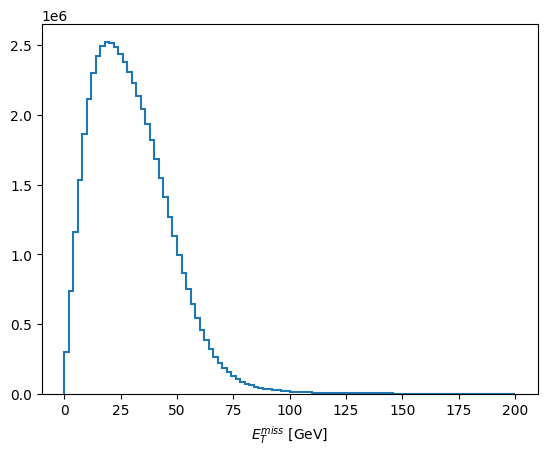

In [4]:
import uproot
import hist.dask as dah
import time

tic = time.monotonic()
dah.Hist.new \
   .Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]").Double() \
   .fill(met=uproot.dask({"./Run2012B_SingleMu.root": "Events"}, steps_per_file=10).MET_pt) \
   .compute().plot();


print(time.monotonic() - tic)

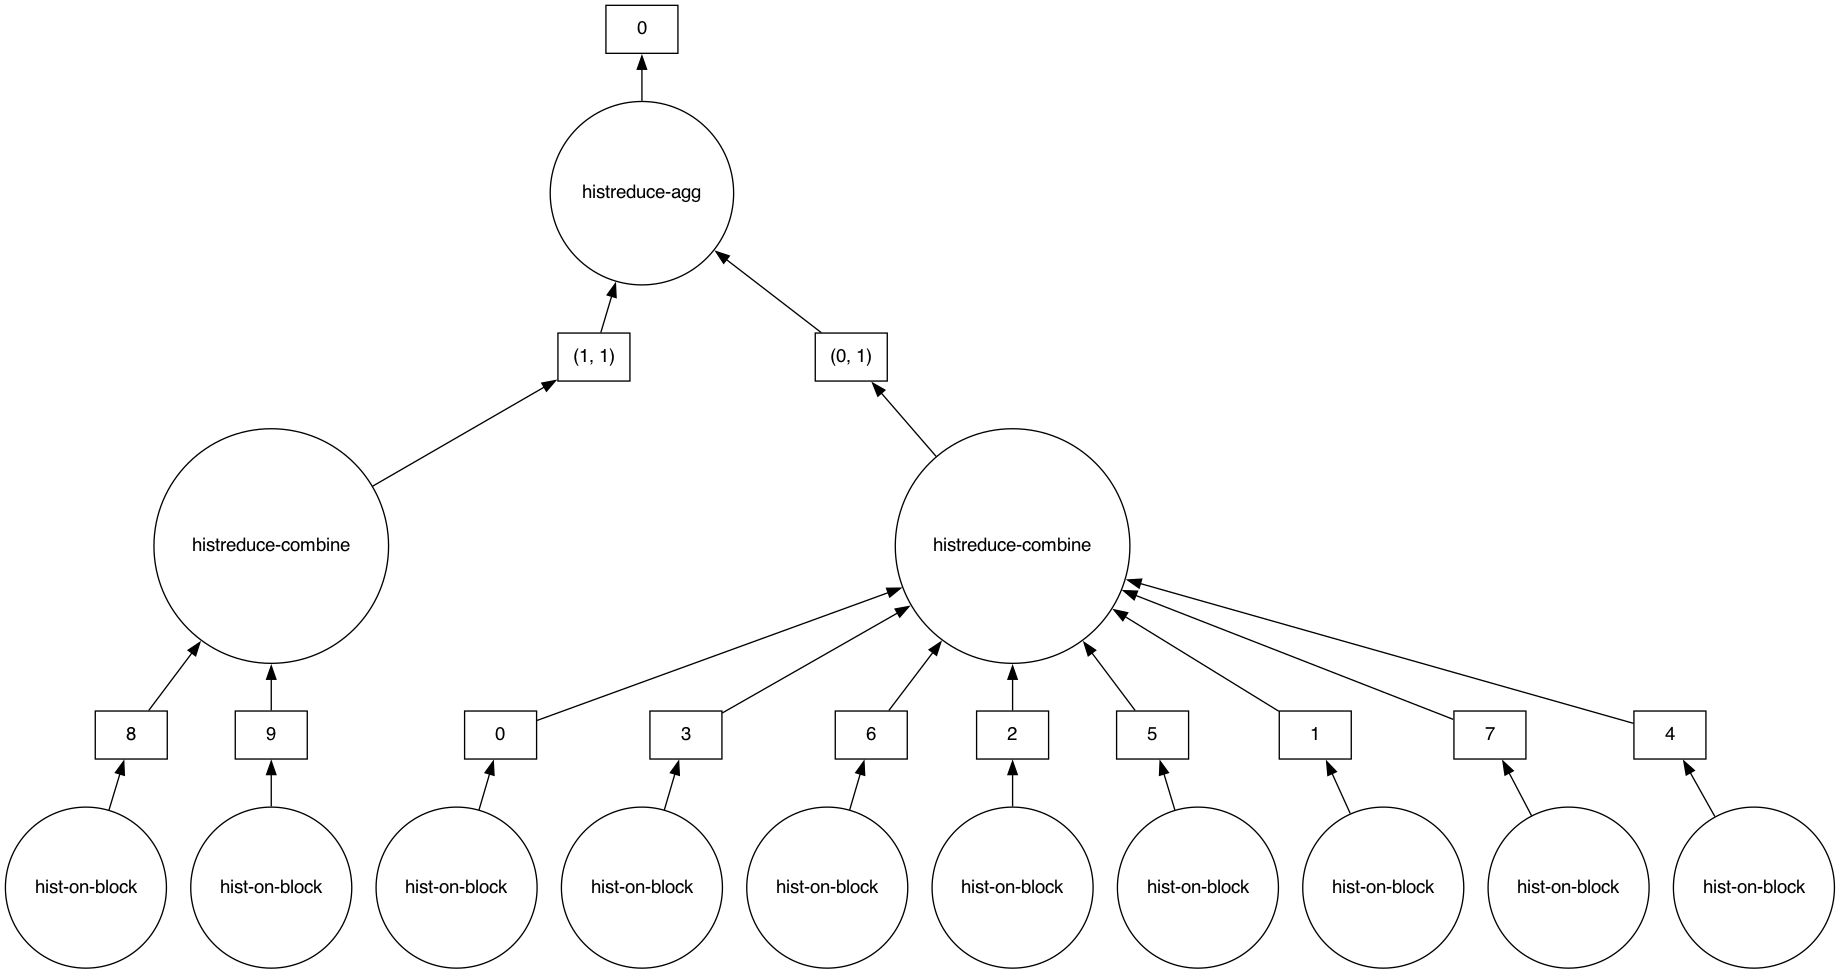

In [6]:
dah.Hist.new \
   .Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]").Double() \
   .fill(met=uproot.dask("./Run2012B_SingleMu.root:Events", steps_per_file=10).MET_pt)\
   .visualize(optimize_graph=True)

Cute - right?

## HEP Analysis is structured: 

<img src="https://github.com/lgray/dask-demo-day-20042023/blob/main/Multijets_3D.jpg?raw=true">

HEP datasets are composed of (up to) billions of recorded or simulated events that contain information
from various detectors (think "very fast cameras"), pattern recognition algorithms are applied to those
data to produce higher level physics data that represents certain kinds of particles with various properties
like mass, charge, type. These high-level physics data allow us to test hypotheses about the fundamental 
structure of the universe.

Within each event there can be varying amounts of many kinds of particles reconstructed from a mixture of
detector signatures:
<img src="https://github.com/lgray/dask-demo-day-20042023/blob/main/particle_flow_figure.png?raw=true">

Organizing this data in an object-oriented way is extremely convenient for clarity of thought, but bad
for array programming and parallelism. We've created an overlay that uses these physics organizational
concepts atop array-based data using awkward array called "nanoevents". We can do this while keeping
the underlying dataset extremely simple (just arrays, no structure), meaning that we can avoid
complexity in our files to keep them efficient while still maintaining a powerful and convenient 
representation of the data for the user.
<img src="https://github.com/lgray/dask-demo-day-20042023/blob/main/nanoevents_diagram.png?raw=true">

In the following example we'll discuss HEP data and the usage of nanoevents in dask to represent our data
transformations.

In [7]:
from coffea.nanoevents import NanoEventsFactory
import dask_awkward as dak

events = NanoEventsFactory.from_root(
    "tests/samples/nano_dy.root", 
    treepath="Events", 
    metadata={"dataset": "ZJets"}, 
    permit_dask=True
).events()

print(events)
print(dak.fields(events))

dask.awkward<from-uproot, npartitions=1>
['SoftActivityJetHT2', 'GenJet', 'GenPart', 'fixedGridRhoFastjetAll', 'SoftActivityJetNjets5', 'SV', 'fixedGridRhoFastjetCentralNeutral', 'HTXS', 'genTtbarId', 'SubGenJetAK8', 'Electron', 'HLTriggerFirstPath', 'GenMET', 'SoftActivityJetNjets2', 'SoftActivityJet', 'Muon', 'CorrT1METJet', 'GenVisTau', 'SoftActivityJetNjets10', 'L1simulation', 'TkMET', 'ChsMET', 'fixedGridRhoFastjetCentral', 'IsoTrack', 'LHEPdfWeight', 'fixedGridRhoFastjetCentralChargedPileUp', 'LHEReweightingWeight', 'Flag', 'SoftActivityJetHT5', 'Jet', 'FsrPhoton', 'CaloMET', 'genWeight', 'HLT', 'btagWeight', 'Tau', 'run', 'HLTriggerFinalPath', 'PSWeight', 'MET', 'SoftActivityJetHT', 'Generator', 'TrigObj', 'LHEWeight', 'GenJetAK8', 'GenDressedLepton', 'L1', 'Pileup', 'PV', 'LHEPart', 'RawMET', 'L1Reco', 'PuppiMET', 'FatJet', 'LHEScaleWeight', 'SoftActivityJetHT10', 'event', 'fixedGridRhoFastjetCentralCalo', 'OtherPV', 'LHE', 'luminosityBlock', 'SubJet', 'Photon']


/Users/lgray/coffea-dev/coffea/coffea/nanoevents/schemas/nanoaod.py:215: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


In [8]:
print(dak.fields(events.Muon))
print(events.Muon.pt)
print(events.Muon.pt.compute())

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'softMva', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'jetIdx', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'fsrPhotonIdx', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartIdx', 'genPartFlav', 'cleanmask', 'fsrPhotonIdxG', 'genPartIdxG', 'jetIdxG']
dask.awkward<pt, npartitions=1>
[[], [], [], [], [76.8, 20.1], [31], [...], ..., [], [17.9], [], [], [], [], []]


We can even access extremely rich per-event data about simulation information, which allows
us to understand how to construct our analyses better or create precise ML training datasets.

In [9]:
events.GenPart[
    (abs(events.GenPart.pdgId) == 13) & 
    events.GenPart.hasFlags("isHardProcess")
].parent.pdgId.compute()

<Array [[], [], [], [], ..., [23, 23], [], []] type='40 * var * ?int32[para...'>

## Example 2: HEP Analyses create large task graphs!

In the following example we'll descend into a more complex analysis operation, the application of jet energy corrections.
We'll inspect the task graph for jet energy corrections and explore how dask optimizes this, including parallelization of systematic uncertainty variations and filling of histograms using a b-tagging SF weight.

Aside from the set of corrections being used, and some errors in their proper application, this is realistic to what would be in an analysis.

In [10]:
from distributed import Client

client = Client(n_workers=5, threads_per_worker=2, memory_limit="2GB")

2023-04-18 19:53:52,928 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-zf9w20ft', purging
2023-04-18 19:53:52,928 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-z6p0x9ee', purging
2023-04-18 19:53:52,929 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-j7wumwdl', purging
2023-04-18 19:53:52,929 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-7eaqb4lj', purging
2023-04-18 19:53:52,929 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_8/wdyynsx91n91t7x7xwn69bsc0000gn/T/dask-worker-space/worker-8246w5kg', purging


In [11]:
def jetmet_evaluator():
    from coffea.lookup_tools import extractor

    extract = extractor()

    extract.add_weight_sets(
        [
            "* * tests/samples/Summer16_23Sep2016V3_MC_L1FastJet_AK4PFPuppi.jec.txt.gz",
            "* * tests/samples/Summer16_23Sep2016V3_MC_L2L3Residual_AK4PFPuppi.jec.txt.gz",
            "* * tests/samples/Summer16_23Sep2016V3_MC_L2Relative_AK4PFPuppi.jec.txt.gz",
            "* * tests/samples/Summer16_23Sep2016V3_MC_L3Absolute_AK4PFPuppi.jec.txt.gz",
            "* * tests/samples/Summer16_23Sep2016V3_MC_UncertaintySources_AK4PFPuppi.junc.txt.gz",
            "* * tests/samples/Summer16_23Sep2016V3_MC_Uncertainty_AK4PFPuppi.junc.txt.gz",
            "* * tests/samples/Fall17_17Nov2017_V6_MC_UncertaintySources_AK4PFchs.junc.txt.gz",
            "* * tests/samples/RegroupedV2_Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.junc.txt.gz",
            "* * tests/samples/Regrouped_Fall17_17Nov2017_V32_MC_UncertaintySources_AK4PFchs.junc.txt",
            "* * tests/samples/Spring16_25nsV10_MC_PtResolution_AK4PFPuppi.jr.txt.gz",
            "* * tests/samples/Spring16_25nsV10_MC_SF_AK4PFPuppi.jersf.txt.gz",
            "* * tests/samples/Autumn18_V7_MC_SF_AK4PFchs.jersf.txt.gz",
            "* * ./btagging.corr.json.gz",
        ]
    )

    extract.finalize()

    return extract.make_evaluator()


evaluator = jetmet_evaluator()

/Users/lgray/miniforge3/envs/coffea-dev/lib/python3.8/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 17.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [12]:
import os
import time
import awkward as ak
import dask_awkward as dak
import numpy as np

from coffea.jetmet_tools import CorrectedJetsFactory, CorrectedMETFactory, JECStack

events = None
from coffea.nanoevents import NanoEventsFactory

events = NanoEventsFactory.from_root(
    "tests/samples/nano_dy.root", 
    treepath="Events", 
    metadata={"dataset": "ZJets"}, 
    permit_dask=True
).events()

/Users/lgray/coffea-dev/coffea/coffea/nanoevents/schemas/nanoaod.py:215: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


In [13]:
jec_stack_names = [
    "Summer16_23Sep2016V3_MC_L1FastJet_AK4PFPuppi",
    "Summer16_23Sep2016V3_MC_L2Relative_AK4PFPuppi",
    "Summer16_23Sep2016V3_MC_L2L3Residual_AK4PFPuppi",
    "Summer16_23Sep2016V3_MC_L3Absolute_AK4PFPuppi",
    "Spring16_25nsV10_MC_PtResolution_AK4PFPuppi",
    "Spring16_25nsV10_MC_SF_AK4PFPuppi",
]
for key in evaluator.keys():
    if "Summer16_23Sep2016V3_MC_UncertaintySources_AK4PFPuppi" in key:
        jec_stack_names.append(key)

jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)

name_map = jec_stack.blank_name_map
name_map["JetPt"] = "pt"
name_map["JetMass"] = "mass"
name_map["JetEta"] = "eta"
name_map["JetA"] = "area"

jets = events.Jet[abs(events.Jet.eta) < 2.5]

jets["pt_raw"] = (1 - jets["rawFactor"]) * jets["pt"]
jets["mass_raw"] = (1 - jets["rawFactor"]) * jets["mass"]
jets["pt_gen"] = dak.fill_none(jets.matched_gen.pt, 0)
jets["rho"] = events.fixedGridRhoFastjetAll
name_map["ptGenJet"] = "pt_gen"
name_map["ptRaw"] = "pt_raw"
name_map["massRaw"] = "mass_raw"
name_map["Rho"] = "rho"

print(name_map)

tic = time.time()
jet_factory = CorrectedJetsFactory(name_map, jec_stack)
toc = time.time()

print("setup corrected jets time =", toc - tic)

tic = time.time()
corrected_jets = jet_factory.build(jets)
toc = time.time()

print("corrected_jets build time =", toc - tic)

{'JetPhi': None, 'JetPt': 'pt', 'METpt': None, 'ptRaw': 'pt_raw', 'massRaw': 'mass_raw', 'JetA': 'area', 'JetMass': 'mass', 'METphi': None, 'UnClusteredEnergyDeltaY': None, 'UnClusteredEnergyDeltaX': None, 'JetEta': 'eta', 'Rho': 'rho', 'ptGenJet': 'pt_gen'}
setup corrected jets time = 4.1961669921875e-05
corrected_jets build time = 0.4798417091369629


In [14]:
import awkward as ak
import dask_awkward as dak
import dask_histogram as dhist
import dask_histogram.boost as dhb

import hist.dask

tic = time.monotonic()

dahist = hist.dask.Hist(
    hist.axis.StrCategory([], growth=True, name="systematic"),
    hist.axis.Regular(40, 0, 400, name="pt"),
    storage=hist.storage.Weight(),
)

deepjet_sf = evaluator["deepJet_comb"]
arrays = {}
central_weight = deepjet_sf("central", "M", 5, abs(corrected_jets.eta), corrected_jets.pt)
dahist.fill("central", dak.flatten(corrected_jets.pt), weight=dak.flatten(central_weight))
arrays["central"] = (corrected_jets.pt, central_weight)

for unc in jet_factory.uncertainties():
    up_weight = deepjet_sf("central", "M", 5, abs(corrected_jets[unc].up.eta), corrected_jets[unc].up.pt)
    down_weight = deepjet_sf("central", "M", 5, abs(corrected_jets[unc].down.eta), corrected_jets[unc].down.pt)
    dahist.fill(systematic=f"{unc}_up", pt=dak.flatten(corrected_jets[unc].up.pt), weight=dak.flatten(up_weight))
    dahist.fill(systematic=f"{unc}_down", pt=dak.flatten(corrected_jets[unc].down.pt), weight=dak.flatten(down_weight))
    
    arrays[f"{unc}_up"] = (corrected_jets[unc].up.pt, up_weight)
    arrays[f"{unc}_down"] = (corrected_jets[unc].down.pt, down_weight)
        
print(time.monotonic() - tic)

0.3792164999999983


In [ ]:
dahist.dask

In [ ]:
import dask
dask.optimize(dahist)[0].dask

In [17]:
tic = time.monotonic()

output = dahist.compute()

print(time.monotonic() - tic)

5.448194874999999


In [18]:
output

Hist(
  StrCategory(['central', 'JER_up', 'JER_down', 'JES_AbsoluteStat_up', 'JES_AbsoluteStat_down', 'JES_AbsoluteScale_up', 'JES_AbsoluteScale_down', 'JES_AbsoluteFlavMap_up', 'JES_AbsoluteFlavMap_down', 'JES_AbsoluteMPFBias_up', 'JES_AbsoluteMPFBias_down', 'JES_Fragmentation_up', 'JES_Fragmentation_down', 'JES_SinglePionECAL_up', 'JES_SinglePionECAL_down', 'JES_SinglePionHCAL_up', 'JES_SinglePionHCAL_down', 'JES_FlavorQCD_up', 'JES_FlavorQCD_down', 'JES_TimePtEta_up', 'JES_TimePtEta_down', 'JES_RelativeJEREC1_up', 'JES_RelativeJEREC1_down', 'JES_RelativeJEREC2_up', 'JES_RelativeJEREC2_down', 'JES_RelativeJERHF_up', 'JES_RelativeJERHF_down', 'JES_RelativePtBB_up', 'JES_RelativePtBB_down', 'JES_RelativePtEC1_up', 'JES_RelativePtEC1_down', 'JES_RelativePtEC2_up', 'JES_RelativePtEC2_down', 'JES_RelativePtHF_up', 'JES_RelativePtHF_down', 'JES_RelativeBal_up', 'JES_RelativeBal_down', 'JES_RelativeFSR_up', 'JES_RelativeFSR_down', 'JES_RelativeStatFSR_up', 'JES_RelativeStatFSR_down', 'JES_RelativeStatEC_up', 'JES_RelativeStatEC_down', 'JES_RelativeStatHF_up', 'JES_RelativeStatHF_down', 'JES_PileUpDataMC_up', 'JES_PileUpDataMC_down', 'JES_PileUpPtRef_up', 'JES_PileUpPtRef_down', 'JES_PileUpPtBB_up', 'JES_PileUpPtBB_down', 'JES_PileUpPtEC1_up', 'JES_PileUpPtEC1_down', 'JES_PileUpPtEC2_up', 'JES_PileUpPtEC2_down', 'JES_PileUpPtHF_up', 'JES_PileUpPtHF_down', 'JES_PileUpMuZero_up', 'JES_PileUpMuZero_down', 'JES_PileUpEnvelope_up', 'JES_PileUpEnvelope_down', 'JES_SubTotalPileUp_up', 'JES_SubTotalPileUp_down', 'JES_SubTotalRelative_up', 'JES_SubTotalRelative_down', 'JES_SubTotalPt_up', 'JES_SubTotalPt_down', 'JES_SubTotalScale_up', 'JES_SubTotalScale_down', 'JES_SubTotalAbsolute_up', 'JES_SubTotalAbsolute_down', 'JES_SubTotalMC_up', 'JES_SubTotalMC_down', 'JES_Total_up', 'JES_Total_down', 'JES_TotalNoFlavor_up', 'JES_TotalNoFlavor_down', 'JES_TotalNoTime_up', 'JES_TotalNoTime_down', 'JES_TotalNoFlavorNoTime_up', 'JES_TotalNoFlavorNoTime_down', 'JES_FlavorZJet_up', 'JES_FlavorZJet_down', 'JES_FlavorPhotonJet_up', 'JES_FlavorPhotonJet_down', 'JES_FlavorPureGluon_up', 'JES_FlavorPureGluon_down', 'JES_FlavorPureQuark_up', 'JES_FlavorPureQuark_down', 'JES_FlavorPureCharm_up', 'JES_FlavorPureCharm_down', 'JES_FlavorPureBottom_up', 'JES_FlavorPureBottom_down', 'JES_TimeRunBCD_up', 'JES_TimeRunBCD_down', 'JES_TimeRunEF_up', 'JES_TimeRunEF_down', 'JES_TimeRunG_up', 'JES_TimeRunG_down', 'JES_TimeRunH_up', 'JES_TimeRunH_down', 'JES_CorrelationGroupMPFInSitu_up', 'JES_CorrelationGroupMPFInSitu_down', 'JES_CorrelationGroupIntercalibration_up', 'JES_CorrelationGroupIntercalibration_down', 'JES_CorrelationGroupbJES_up', 'JES_CorrelationGroupbJES_down', 'JES_CorrelationGroupFlavor_up', 'JES_CorrelationGroupFlavor_down', 'JES_CorrelationGroupUncorrelated_up', 'JES_CorrelationGroupUncorrelated_down'], growth=True, name='systematic'),
  Regular(40, 0, 400, name='pt'),
  storage=Weight()) # Sum: WeightedSum(value=12228, variance=11920.9)

In [ ]:
exec(open("./yimu_test5.py").read())
output['HT'].dask